In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle as pkl
import time

from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

np.set_printoptions(linewidth=150)
pd.set_option('display.max_columns', 500)

from graph2net.parser import parse

# Red Hat Plots

## Macro

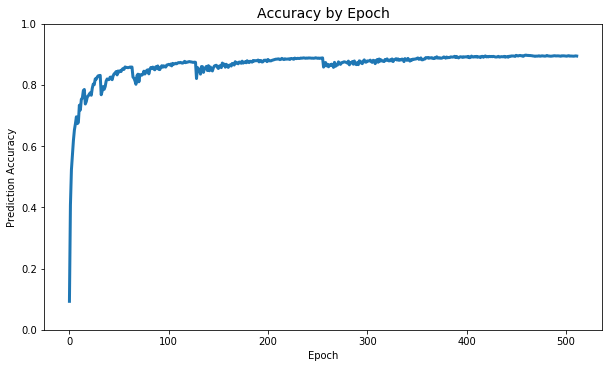

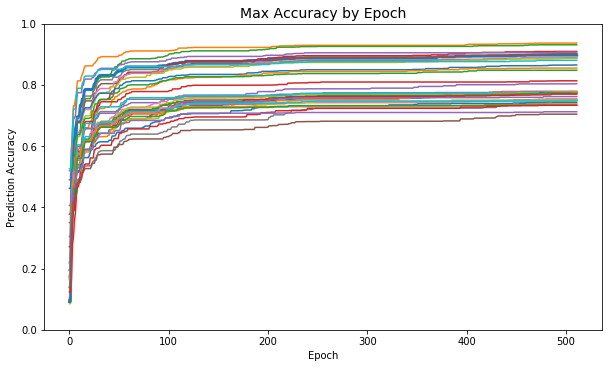

In [45]:
def cumul_max(l):
    return [max(l[:i]) if i else l[0] for i in range(len(l))]

figsize = (10,5.63)
dpi = 250
linewidth = 3
label_fontsize = 10
title_fontsize = 14

plt.figure(figsize=figsize)
record_rows = run_stats.sort_values(by='max',ascending=False)
record_rows = record_rows[record_rows['epoch']>500].iloc[:36]
record_rows['curve']=record_rows['curve'].apply(lambda x: [val/10000 for val in x])

for idx,row in list(record_rows.iterrows())[5:6]:
    plt.plot(row['curve'],linewidth=linewidth)
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
plt.savefig("red_hat_figures/solo_raw.png",dpi=dpi)
plt.show()

plt.figure(figsize=figsize)
for idx,row in list(record_rows.iterrows())[5:6]:
    plt.plot(cumul_max(row['curve']),linewidth=linewidth)
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
#plt.savefig("red_hat_figures/solo_max.png",dpi=dpi)


for i,(idx,row) in enumerate(record_rows.iterrows()):
    save=False
    if i!=5:
        plt.plot(cumul_max(row['curve']))
        plt.xlabel("Epoch",fontsize=label_fontsize)
        plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
        plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
        plt.ylim(0,1)
    if i<5 or not (i-5)%10:
        pass
        #plt.savefig("plots_and_figures/red_hat_figures/plot_{}.png".format(i),dpi=dpi)
plt.show()

<Figure size 720x405.36 with 0 Axes>

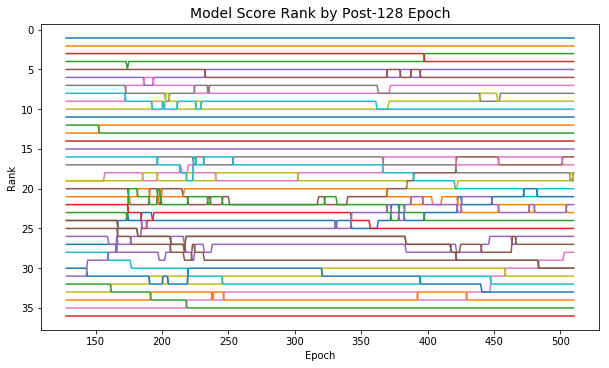

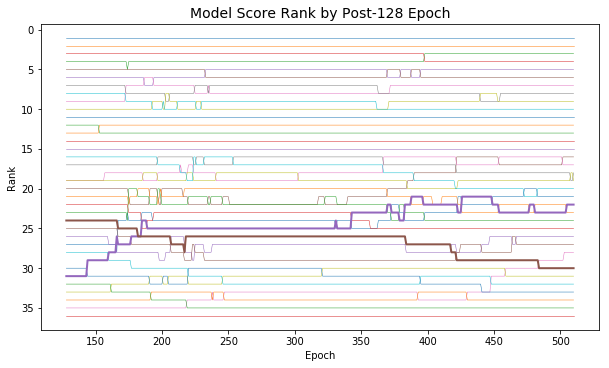

0     0
1     0
2     1
3    -1
4     1
5    -1
6     2
7    -1
8     1
9    -2
10    0
11    1
12   -1
13    0
14    0
15    4
16    2
17   -1
18    0
19   -4
20    6
21    9
22   -2
23   -1
24   -3
25    0
26   -2
27    7
28    0
29   -6
30    2
31   -4
32   -3
33    0
34   -3
35    0
Name: rank_delta, dtype: int64

In [161]:
import scipy.stats as ss        

plt.figure(figsize=figsize)
curves = record_rows['curve']
ranks = []
for epoch in range(1,512):
    best = [max(curve[:epoch]) for curve in curves]
    rank = ss.rankdata(best,method='min')
    rank = max(rank)+1-rank
    ranks.append(rank)
    
#print(ranks)
plt.figure(figsize=figsize)
plt.plot(range(128,511),[list(x[:21])+list(x[22:28])+list(x[29:]) for x in ranks[128:]])
plt.plot(range(128,511),[[x[21],x[29]] for x in ranks[128:]])
plt.xlabel("Epoch",fontsize=label_fontsize)
plt.ylabel("Rank",fontsize=label_fontsize)
plt.title("Model Score Rank by Post-128 Epoch",fontsize=title_fontsize)
plt.gca().invert_yaxis()
plt.savefig("plots_and_figures/red_hat_figures/ranks_128.png",dpi=dpi)
plt.show()

plt.figure(figsize=figsize)
plt.plot(range(128,511),[list(x[:21])+list(x[22:28])+list(x[29:]) for x in ranks[128:]],linewidth=.5)
plt.plot(range(128,511),[[x[21],x[29]] for x in ranks[128:]],linewidth=2)
plt.xlabel("Epoch",fontsize=label_fontsize)
plt.ylabel("Rank",fontsize=label_fontsize)
plt.gca().invert_yaxis()
plt.title("Model Score Rank by Post-128 Epoch",fontsize=title_fontsize)
plt.savefig("plots_and_figures/red_hat_figures/ranks_128_max_delta.png",dpi=dpi)
plt.show()


rank_df = pd.DataFrame(ranks).T
rank_df['rank_delta']=rank_df[128]-rank_df[510]
rank_df['rank_delta']

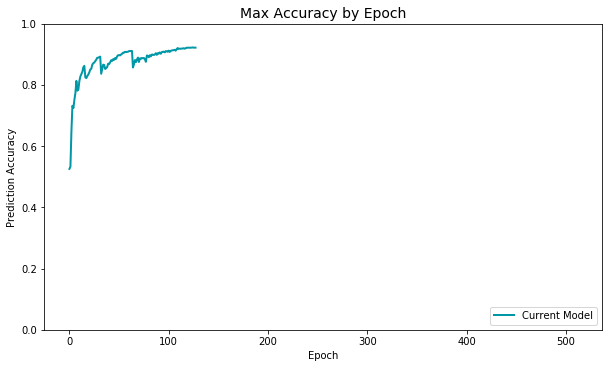

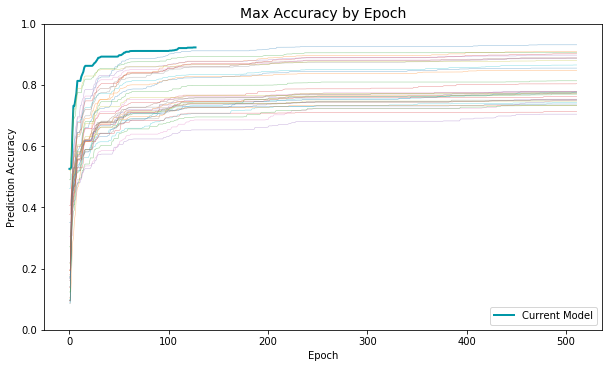

In [167]:
plt.figure(figsize=figsize)
for idx,row in list(record_rows.iterrows())[:1]:
    plt.plot(row['curve'][:128],linewidth=2,label="Current Model",color="#0097A7")
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
plt.xlim(-25.55,536.55)
plt.legend(loc='lower right')
plt.savefig("plots_and_figures/red_hat_figures/solo_test_run_raw.png",dpi=dpi)

plt.figure(figsize=figsize)
for idx,row in list(record_rows.iterrows())[:1]:
    plt.plot(cumul_max(row['curve'])[:128],linewidth=2,label="Current Model",color="#0097A7")
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
plt.xlim(-25.55,536.55)
plt.legend(loc='lower right')
plt.savefig("plots_and_figures/red_hat_figures/solo_test_run.png",dpi=dpi)

for i,(idx,row) in enumerate(record_rows.iterrows()):
    if i:
        plt.plot(cumul_max(row['curve']),linewidth=.5,alpha=.5)
        plt.xlabel("Epoch",fontsize=label_fontsize)
        plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
        plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
        plt.ylim(0,1)

plt.savefig("plots_and_figures/red_hat_figures/group_test_run.png",dpi=dpi)
plt.show()

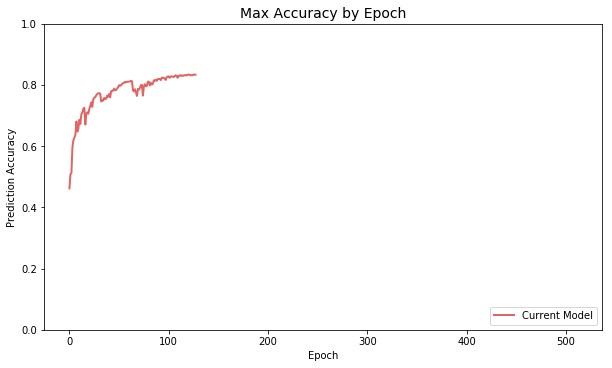

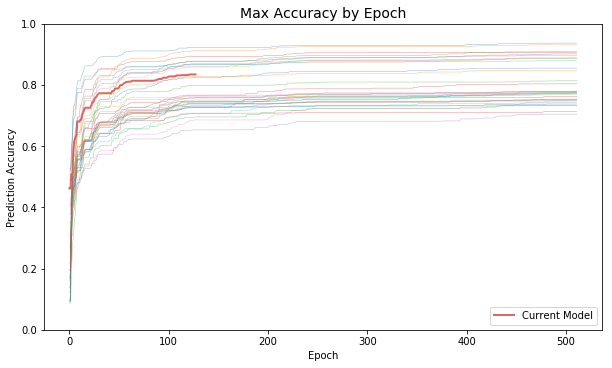

In [168]:
plt.figure(figsize=figsize)
for idx,row in list(record_rows.iterrows())[10:11]:
    plt.plot(row['curve'][:128],linewidth=2,label="Current Model",color="#E06666")
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
plt.xlim(-25.55,536.55)
plt.legend(loc='lower right')
plt.savefig("plots_and_figures/red_hat_figures/solo_test_run_bad_raw.png",dpi=dpi)


plt.figure(figsize=figsize)
for idx,row in list(record_rows.iterrows())[10:11]:
    plt.plot(cumul_max(row['curve'])[:128],linewidth=2,label="Current Model",color="#E06666")
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
plt.xlim(-25.55,536.55)
plt.legend(loc='lower right')
plt.savefig("plots_and_figures/red_hat_figures/solo_test_run_bad.png",dpi=dpi)

for i,(idx,row) in enumerate(record_rows.iterrows()):
    if i!=10:
        plt.plot(cumul_max(row['curve']),linewidth=.5,alpha=.5)
        plt.xlabel("Epoch",fontsize=label_fontsize)
        plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
        plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
        plt.ylim(0,1)

plt.savefig("plots_and_figures/red_hat_figures/group_test_run_bad.png",dpi=dpi)
plt.show()

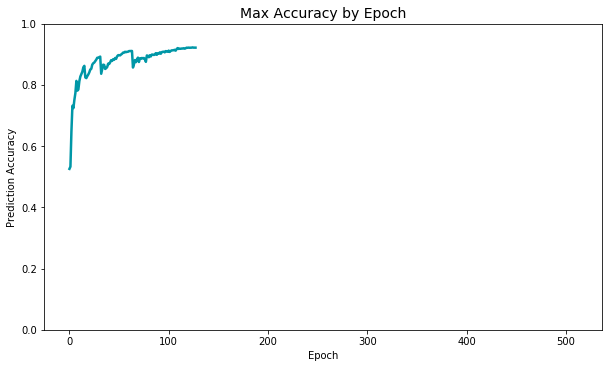

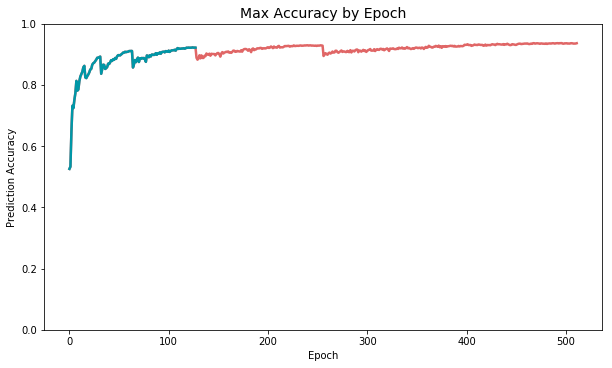

In [173]:
plt.figure(figsize=figsize)
for idx,row in list(record_rows.iterrows())[:1]:
    plt.plot(row['curve'][:128],linewidth=2.5,color='#0097A7')
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
plt.xlim(-25.55,536.55)
plt.savefig("plots_and_figures/red_hat_figures/solo_test_run_128.png",dpi=dpi)

plt.figure(figsize=figsize)
for idx,row in list(record_rows.iterrows())[:1]:
    plt.plot(row['curve'],linewidth=2.5,color='#E06666')
    plt.plot(row['curve'][:128],linewidth=2.5,color='#0097A7')
    plt.xlabel("Epoch",fontsize=label_fontsize)
    plt.ylabel("Prediction Accuracy",fontsize=label_fontsize)
    plt.title("Max Accuracy by Epoch",fontsize=title_fontsize)
plt.ylim(0,1)
plt.xlim(-25.55,536.55)

plt.savefig("plots_and_figures/red_hat_figures/solo_test_run_512.png",dpi=dpi)

# See Current Run Predictions

Epoch 21
Current Score: 7736, Max Score: 7767, Record Score: 9368


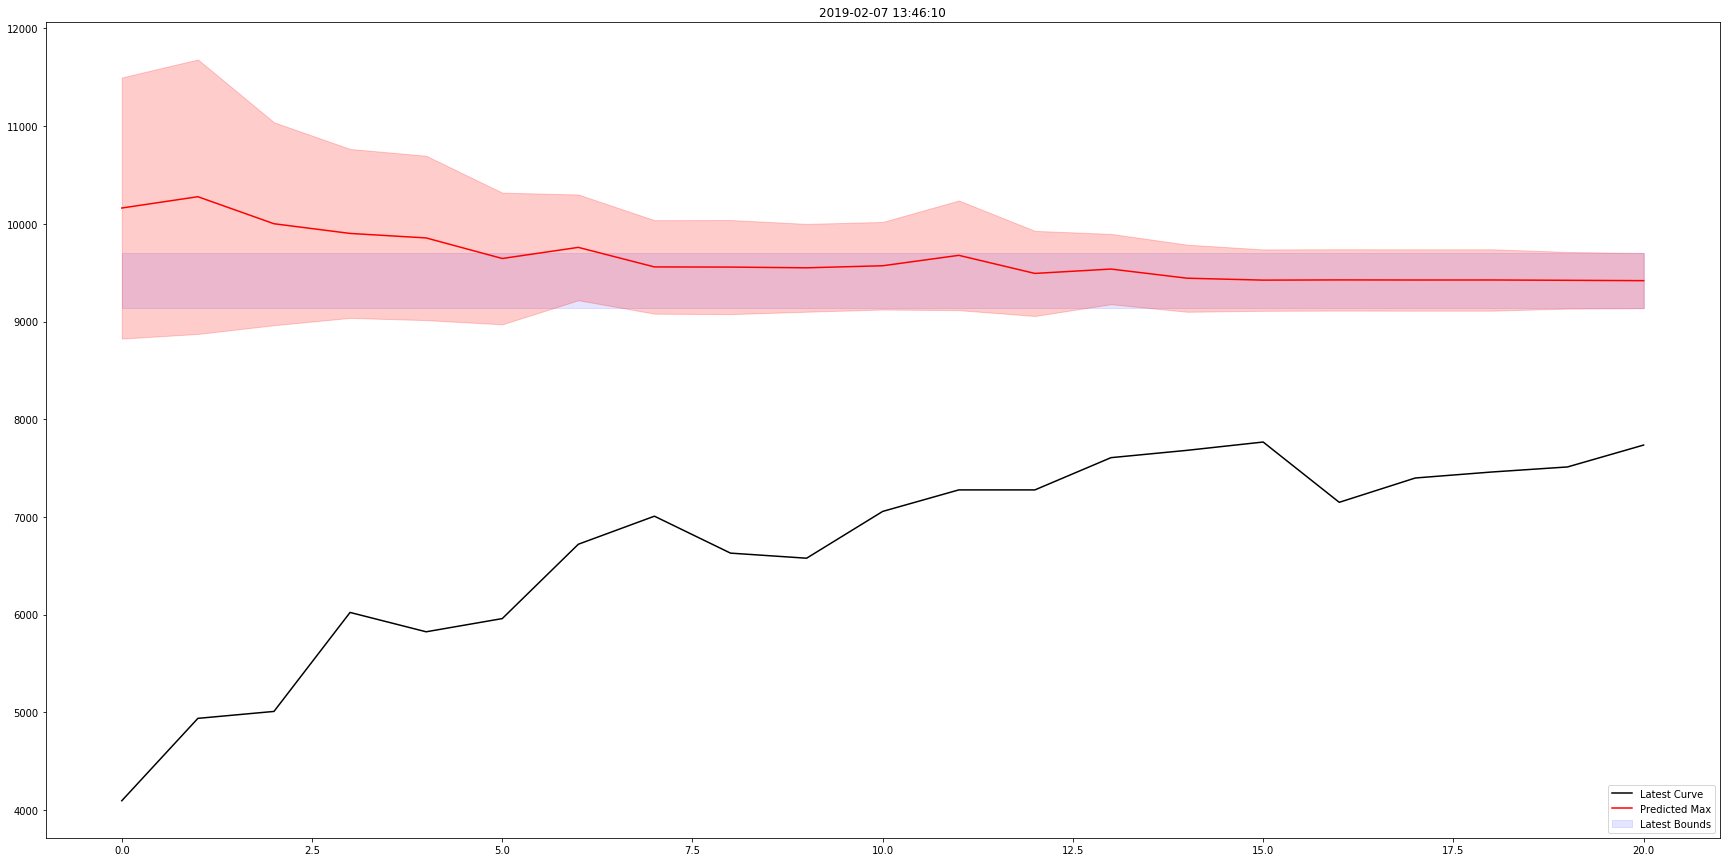

In [112]:
def pred_plot(row,solo=True):
    funcs = pkl.load(open('macro_loss_predictors.pkl',"rb"))
    curve_len = len(row['curve'])
    print("Epoch",curve_len)
    print("Current Score: {}, Max Score: {}, Record Score: {:.0f}".format(row['curve'][-1],max(row['curve']),record))
    if solo:
        plt.figure(figsize=(30,15))
    plt.plot(row['curve'],color='black',label='Latest Curve')
    preds = []
    
    for i in range(curve_len):
        X = row[['max_curve_{}'.format(i),'params','parallel','cells','nodes','scale','lr_max']]
        preds.append(funcs[i]['b']+np.dot(X,funcs[i]['m']))
    preds = np.array(preds)
    c95s = np.array([value['95'] for (key,value) in list(funcs.items())[:curve_len]])
    
    if curve_len==512:
        plt.plot([max(row['curve'])]*curve_len,label="Actual Max",color='black',linestyle='dashed')
        plt.plot(preds,label="Predicted Max",color='red')
    else:
        if solo:
            pass
            plt.fill_between(range(curve_len),(preds+c95s)[-1],(preds-c95s)[-1],color='blue',alpha=.1,label="Latest Bounds")
            plt.plot(preds,label="Predicted Max",color='red')
        else:
            pass
            #plt.fill_between(range(curve_len-1,512),(preds+c95s)[-1],(preds-c95s)[-1],color='pink',alpha=.2,label="Latest Bounds")
            #plt.plot(list(preds)+[preds[-1]]*(512-curve_len-1),label="Predicted Max",color='red',alpha=.3)
    if solo:
        plt.fill_between(range(curve_len),preds+c95s,preds-c95s,color='red',alpha=.2)
    
    
    if solo:
        plt.title(row['run_date'])
        plt.legend(loc='lower right')
        plt.show()
    
last = macro_process(parse(last=True)).iloc[0]
pred_plot(last)

# See Current Run Compared to Best Macro Runs

In [113]:
def next_powers(x):
    return [2**i for i in range(1,10) if (2**i)>x]

In [174]:
while 1:
    plt.figure(figsize=(30,15))
    last = macro_process(parse(last=True)).iloc[0]

    curr_epoch = last['epoch']

    # plot top runs
    best_runs = []
    for i,row in run_stats.iterrows():
        if 256<len(row['curve']) and max(row['curve'])>=8000:
            plt.plot(row['curve'],alpha=.5)
            best_runs.append(row['curve'])

    # plot benchmarks
    plt.plot(range(512),[max(run_stats['max'])]*512,linestyle="dotted",label="PB")
    plt.plot(range(512),[9000]*512,linestyle="dotted",label="90%")     
    plt.plot(range(512),[9852]*512,linestyle="dotted",label="WR")     

    # plot latest run
    pred_plot(last,solo=False)
    delta = last['curve'][curr_epoch-1]-run_stats.sort_values(by='max',ascending=False)['curve'].iloc[0][curr_epoch-1]
    if curr_epoch>10:
        best_run = run_stats.sort_values(by='max',ascending=False)['curve'].iloc[0]
        
        powers = next_powers(curr_epoch)
        average_delta=np.mean(np.array(last['curve'][curr_epoch-10:curr_epoch])-best_run[curr_epoch-10:curr_epoch])
        deltas_to_restart = [np.mean([max(x[:power])-max(x[:curr_epoch]) for x in best_runs]) for power in powers]
        best_run_deltas = [max(best_run[:power])-max(best_run[:curr_epoch]) for power in powers]
        
        print("Current Record Delta: {}, Average T-10 Delta: {:.0f}".format(delta,average_delta))
        print("Average Delta to Epoch Restart:",", ".join(["{}: {:.1f}".format(power,deltas_to_restart[i],) for (i,power) in enumerate(powers)]))
        print("Record  Delta to Epoch Restart:",", ".join(["{}: {:.1f}".format(power,best_run_deltas[i]) for (i,power) in enumerate(powers)]))
    else:
        print("Current Record Delta: {}".format(delta))

    # label
    plt.title("CIFAR-10 Loss History, Model Testbed")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='lower right')
    plt.show()
    
    while parse(last=True).iloc[0]['epoch'] == curr_epoch:
        time.sleep(5)
    clear_output()

IndexError: single positional indexer is out-of-bounds

<Figure size 2160x1080 with 0 Axes>